### **Set-up and data loading and cleaning**

In [1]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import style 

In [2]:
df_fx = pd.read_csv('naira_exchange_rates.csv', parse_dates=['Date'])
df_oil = pd.read_csv('crude_oil_prices.csv')
df_inflation = pd.read_csv('inflation_rate.csv')

#### Crude oil price data cleaning

In [3]:
df_oil.head()

,tyear,tmonth,period,crudeOilPrice,domProd,crudeOilExp
0,2025,3,March 2025,74.55,1.40,0.95
1,2025,2,February 2025,77.08,1.47,1.02
2,2025,1,January 2025,80.76,1.54,1.09
3,2024,12,December 2024,74.72,1.48,1.03
4,2024,11,November 2024,75.44,1.49,1.04


In [4]:
# convert date to datetime series
df_oil['date']= pd.to_datetime(df_oil['period'], format='%B %Y')
df_oil['date'].head()

0   2025-03-01
1   2025-02-01
2   2025-01-01
3   2024-12-01
4   2024-11-01
Name: date, dtype: datetime64[ns]

In [5]:
#dropping columns that are not needed
df_oil.drop(axis= 1, columns=['domProd', 'tyear', 'tmonth', 'crudeOilExp', 'period'], inplace=True)
df_oil= df_oil[(df_oil['date'] >= '2009-01-01') & (df_oil['date'] <= '2024-12-31')]
df_oil= df_oil.rename(columns={'crudeOilPrice':'crude_oil_price'})
df_oil.head()

,crude_oil_price,date
3,74.72,2024-12-01
4,75.44,2024-11-01
5,76.69,2024-10-01
6,76.05,2024-09-01
7,82.88,2024-08-01


#### Inflation rate data cleaning

In [6]:
# convert date column to datetime series

df_inflation['date']= pd.to_datetime(df_inflation['period'], format='%B %Y')
df_inflation['date'].head()

0   2025-03-01
1   2025-02-01
2   2025-01-01
3   2024-12-01
4   2024-11-01
Name: date, dtype: datetime64[ns]

In [7]:
# drop columns that are not needed
df_inflation.drop(axis= 1, columns=['tyear', 'tmonth', 'period', 'allItemsAverage', 'foodYearOn', 'foodAverage', 'allItemsLessFrmProdYearOn', 'allItemsLessFrmProdAverage', 'allItemsLessFrmProdAndEnergyYearOn', 'allItemsLessFrmProdAndEnergyAvg' ], inplace=True)
df_inflation= df_inflation[(df_inflation['date'] >= '2009-01-01') & (df_inflation['date'] <= '2024-12-31')]
df_inflation.rename(columns= {'allItemsYearOn': 'inflation_rate'}, inplace=True ) # renaming column
df_inflation.head()

,inflation_rate,date
3,15.44,2024-12-01
4,34.60,2024-11-01
5,33.88,2024-10-01
6,32.70,2024-09-01
7,32.15,2024-08-01


#### Exchange rate data cleaning

In [8]:
# converting column names to lower case
df_fx.columns= df_fx.columns.str.lower()
df_fx.columns

Index(['currency', 'date', 'buying rate', 'central rate', 'selling rate'], dtype='object')

In [9]:
# dropping columns that re not necessary
df_fx.drop(axis= 1, columns=['buying rate', 'selling rate'], inplace= True)
df_fx= df_fx[(df_fx['date'] >= '2009-01-01') & (df_fx['date'] <= '2024-12-31')]
df_fx.rename(columns= {'central rate': 'central_rate'}, inplace= True) 
display(df_fx.head())
df_fx.duplicated().sum()

,currency,date,central_rate
1104,CFA,2024-12-31,2.4224
1105,YUAN/RENMINBI,2024-12-31,210.3348
1106,DANISH KRONA,2024-12-31,213.8325
1107,EURO,2024-12-31,1594.8879
1108,YEN,2024-12-31,9.7835


34

In [10]:
# cleaning currency names 
df_fx['currency'] = df_fx['currency'].str.strip()
df_fx['currency'] = df_fx['currency'].str.lower()

In [11]:
df_fx.drop_duplicates(inplace= True)
df_fx['currency'].value_counts()

currency
us dollar             3923
riyal                 3918
euro                  3917
pounds sterling       3916
yen                   3914
swiss franc           3912
waua                  3912
sdr                   3902
cfa                   3892
yuan/renminbi         3188
danish krona          3020
south african rand    1914
danish kroner          892
naira                    6
pound sterling           5
japanese yen             1
poeso                    1
Name: count, dtype: int64

In [12]:
# harmonizing currncy names
replace_dict = {'pounds sterling': 'pound sterling', 'japanese yen': 'yen'}
df_fx['currency'] = df_fx['currency'].replace(replace_dict, regex= True)

In [13]:
df_fx['currency'].value_counts()

currency
us dollar             3923
pound sterling        3921
riyal                 3918
euro                  3917
yen                   3915
swiss franc           3912
waua                  3912
sdr                   3902
cfa                   3892
yuan/renminbi         3188
danish krona          3020
south african rand    1914
danish kroner          892
naira                    6
poeso                    1
Name: count, dtype: int64

In [14]:
# selecting the currencies needed
selected = ['us dollar', 'euro', 'pound sterling', 'yen', 'yuan/renminbi', 'south african rand']
df_fx = df_fx[df_fx['currency'].isin(selected)].copy()
df_fx['currency'].value_counts()

currency
us dollar             3923
pound sterling        3921
euro                  3917
yen                   3915
yuan/renminbi         3188
south african rand    1914
Name: count, dtype: int64

In [15]:
#aggregating each currency rate on monthly basis
monthly_fx = (df_fx.groupby([df_fx['date'].dt.to_period('M'), 'currency'])['central_rate'].mean().reset_index())
monthly_fx['date'] = monthly_fx['date'].dt.to_timestamp()
monthly_fx.head()

,date,currency,central_rate
0,2009-01-01,euro,188.866237
1,2009-01-01,pound sterling,205.476815
2,2009-01-01,us dollar,142.256500
3,2009-01-01,yen,1.571433
4,2009-02-01,euro,185.835665


### Creating the merged data frame

In [16]:
# merging the exchange rate, inflation and crude price dataframes
df = monthly_fx.merge(df_oil, on='date', how= 'inner').merge(df_inflation, on='date', how='inner')
df.head()

,date,currency,central_rate,crude_oil_price,inflation_rate
0,2009-01-01,euro,188.866237,44.95,14.0
1,2009-01-01,pound sterling,205.476815,44.95,14.0
2,2009-01-01,us dollar,142.256500,44.95,14.0
3,2009-01-01,yen,1.571433,44.95,14.0
4,2009-02-01,euro,185.835665,46.52,14.6


In [17]:
df.to_csv('naira.csv', index=False) # saving the merged dataframe for streamlit storyboard

In [18]:
# Pivot the exchange rate data for analysis
df_pivot = df.pivot(index='date', columns='currency', values='central_rate')

# Merging with crude oil and inflation (taking one row per date since they're the same across currencies)
df_meta = df[['date', 'crude_oil_price', 'inflation_rate']].drop_duplicates().set_index('date')
df_merged = df_pivot.merge(df_meta, left_index=True, right_index=True)

## Analysis to answer questions on Nigerian Naira exchange rates

#### Q1: What are the long-term trends in NGN exchange rates?


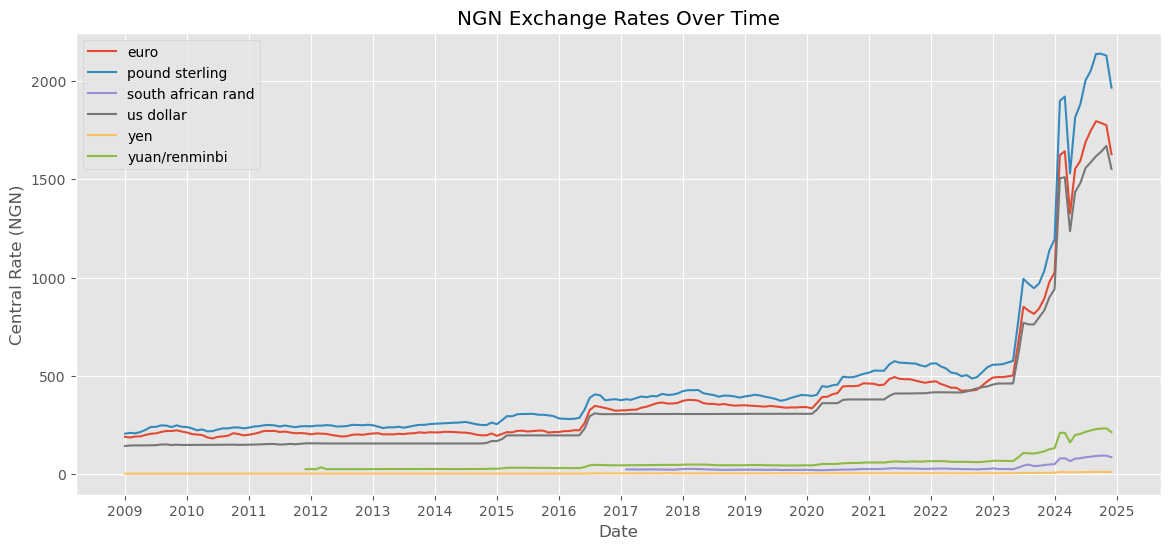

In [19]:
# Line plot for all currencies
style.use('ggplot')
fig, ax = plt.subplots(figsize=(14, 6))
for currency in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[currency], label=currency)
plt.title('NGN Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Central Rate (NGN)')
plt.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show tick for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
plt.grid(True)
plt.show()

Between 2009 and 2024, the Nigerian Naira experienced a long-term downward trend in value, marked by periods of relative stability. The lowest valuation occurred in mid-year to the final quarter of 2024, followed by signs of recovery at the end of the year, indicating a potential shift in market dynamics or policy response.

#### Q2: Which currencies are most volatile vs the Naira?

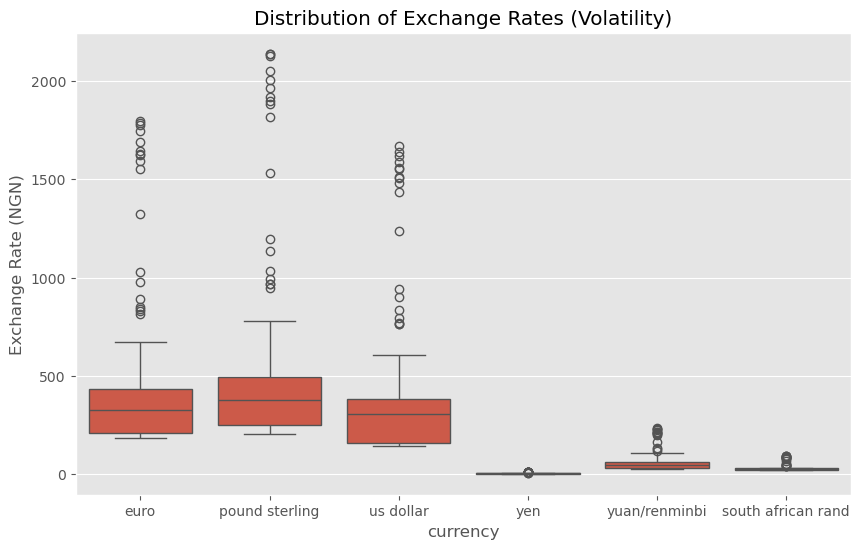

In [20]:
# Box plot of currency volatilities
df_long = df[['date', 'currency', 'central_rate']]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x='currency', y='central_rate')
plt.title('Distribution of Exchange Rates (Volatility)')
plt.ylabel('Exchange Rate (NGN)')
plt.show()

Between 2009 and 2024, Western currencies—particularly the USD, GBP, and EUR—exhibited higher volatility and a greater degree of Naira depreciation over time. In contrast, Asian currencies such as the JPY and CNY, along with the South African Rand, demonstrated more stability, characterized by narrower interquartile ranges and fewer extreme fluctuations.

#### Q3: What is the Rolling Volatility of Exchange Rates?

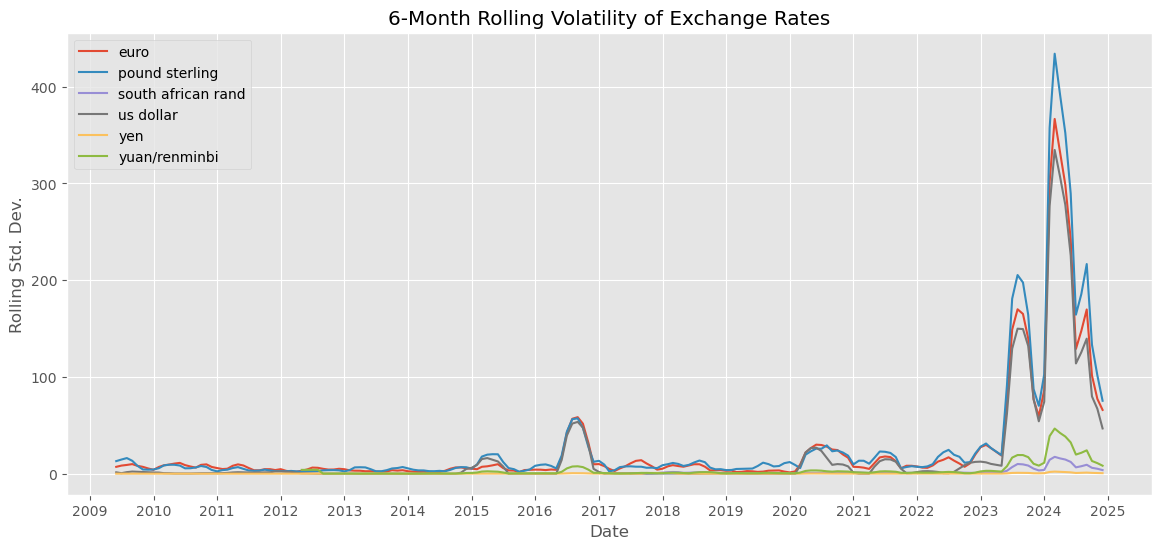

In [21]:
# Rolling volatility (6-month std)
rolling_vol = df_pivot.rolling(6).std()
fig, ax = plt.subplots(figsize=(14, 6))
for currency in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[currency], label=currency)
plt.title("6-Month Rolling Volatility of Exchange Rates")
plt.xlabel("Date")
plt.ylabel("Rolling Std. Dev.")
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show tick for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
plt.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show tick for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
plt.grid(True)
plt.show()

From 2009 to 2024, the Naira saw major devaluations in 2015 followed by a more pronounced depreciation in 2016. This is followed by relative stability until 2020. In 2023, volatility surged again, exceeding 2016 levels, with peaks in mid-2024. By year-end, the Naira showed signs of recovery.

#### Q4: How are exchange rates correlated with oil prices and inflation?


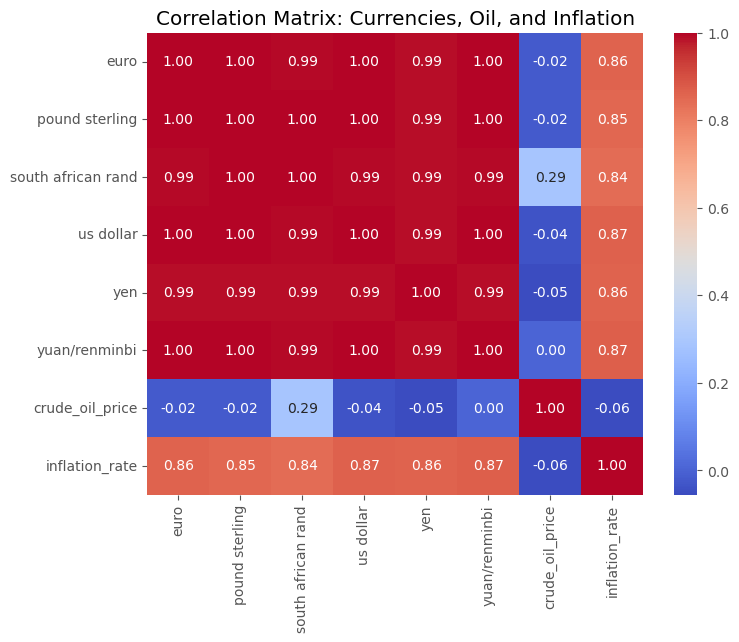

In [22]:
#Correlation matrix (currencies, oil, inflation)
plt.figure(figsize=(8, 6))
sns.heatmap(df_merged.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix: Currencies, Oil, and Inflation")
plt.show()

The correlation matrix reveals that crude oil prices have little to no correlation with the exchange rates of the analyzed currencies. In contrast, the year-on-year inflation rate exhibits a strong positive correlation with these exchange rates, indicating inflation’s significant influence on currency valuation. Additionally, the currencies generally tend to move together, demonstrating strong inter-correlations among themselves.

### **Creating a .py file for a Streamlit Interactive dashboard to present findings**

In [24]:
%%writefile naira_dashboard.py

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import style

st.set_page_config(page_title="🔁 Naira Dynamics: Oil, Inflation And Exchange", layout="centered")

st.title("🔁 Naira Dynamics: Oil, Inflation And Exchange")
st.write('This project analyzes the historical performance (between 2009 and 2024) of the Nigerian Naira (NGN) against six major global currencies, focusing on **exchange rate trends**, **volatility**, and the **influence of crude oil prices and inflation**.')
st.write("""
    This analysis is of value to professional in these spaces:
    * Financial Services & Banking – for FX risk assessment, investment strategy, and economic forecasting
    * Import/Export & Trade – to understand currency exposure and pricing strategy
    * Government & Policy Institutions – for macroeconomic planning and inflation control
    * Oil & Gas – to assess exchange rate risk independent of oil price trends
    * Investment & Asset Management – for currency market analysis and portfolio allocation
    """)

st.markdown("[Click here to explore the project code on GitHub.](https://github.com/Grace-OO/Call_Metrics/tree/main)")
# Load dataset (assumes the file is preloaded, not uploaded)
df = pd.read_csv("naira.csv", parse_dates=['date'])

# Sidebar filters
st.sidebar.header("Filter Data")
years = list(range(2009, 2025))
year_range = st.sidebar.slider("Select Year Range", 2009, 2024, (2009, 2024))
selected_currencies = st.sidebar.multiselect("Select Currencies", df['currency'].unique(), default=list(df['currency'].unique()))

# Filter data
df = df[df['year'].between(year_range[0], year_range[1]) & df['currency'].isin(selected_currencies)]

# Pivot exchange rate data
df_pivot = df.pivot(index='date', columns='currency', values='central_rate')
df_meta = df[['date', 'crude_oil_price', 'inflation_rate']].drop_duplicates().set_index('date')
df_merged = df_pivot.merge(df_meta, left_index=True, right_index=True)

# Sidebar selection

show_chart1 = st.sidebar.checkbox("NGN Exchange Rates Over Time", value=True)
show_chart2 = st.sidebar.checkbox("Volatility of Exchange Rates", value=True)
show_chart3 = st.sidebar.checkbox("Rolling Volatility of Exchange Rates)", value=True)
show_chart4 = st.sidebar.checkbox("Correlation Matrix: Currencies vs Oil/Inflation", value=True)


# Visualization 1: Exchange Rate Trends
if show_chart1:
    st.subheader("NGN Exchange Rates Over Time")
    style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12, 6))
    for col in df_pivot.columns:
        ax.plot(df_pivot.index, df_pivot[col], label=col)
    ax.set_title('NGN vs Major Currencies')
    ax.set_ylabel('Exchange Rate')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Show tick for each year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
    st.pyplot(fig)
    st.write("""
   Between 2009 and 2024, the Nigerian Naira experienced a long-term downward trend in value, marked by periods of relative stability. 
   The lowest valuation occurred in mid-year to the final quarter of 2024, followed by signs of recovery at the end of the year, indicating a potential shift in market dynamics or policy response.
    """)

# Visualization 2: Box Plot
if show_chart2:
    st.subheader("Volatility of Exchange Rates")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x='currency', y='central_rate', ax=ax)
    ax.set_title("Box Plot of NGN Exchange Rates")
    st.pyplot(fig)
    st.write("""
    Between 2009 and 2024, Western currencies—particularly the USD, GBP, and EUR—exhibited higher volatility and a greater degree of Naira depreciation over time. 
    In contrast, Asian currencies such as the JPY and CNY, along with the South African Rand, demonstrated more stability, characterized by narrower interquartile ranges and fewer extreme fluctuations.
    """)

# Visualization 3: Rolling Volatility
if show_chart3:
    st.subheader("Rolling Volatility of Exchange Rates")
    rolling_vol = df_pivot.rolling(6).std()
    fig, ax = plt.subplots(figsize=(12, 6))
    for col in rolling_vol.columns:
        ax.plot(rolling_vol.index, rolling_vol[col], label=col)
    ax.set_title("6-Month Rolling Volatility of Exchange Rates")
    ax.legend()
    ax.set_ylabel("Std Dev")
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Show tick for each year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year
    plt.xticks(rotation=30)
    st.pyplot(fig)
    st.write("""
   From 2009 to 2024, the Naira saw major devaluations in 2015 followed by a more pronounced depreciation in 2016. This is followed by relative stability until 2020. 
   In 2023, volatility surged again, exceeding 2016 levels, with peaks in mid-2024. By year-end, the Naira showed signs of recovery.

    """)

# Visualization 4: Correlation Matrix
if show_chart4:
    st.subheader("Correlation Matrix: Currencies vs Oil/Inflation")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_merged.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    st.pyplot(fig)
    st.write("""
    The correlation matrix reveals that crude oil prices have little to no correlation with the exchange rates of the analyzed currencies. 
    In contrast, the year-on-year inflation rate exhibits a strong positive correlation with these exchange rates, indicating inflation’s significant influence on currency valuation. 
    Additionally, the currencies generally tend to move together, demonstrating strong inter-correlations among themselves.
    """)
    
st.write("#### Summary")
st.write("""
   From 2009 to 2024, the Nigerian Naira faced ongoing depreciation, with major devaluation trends beginning in 2023 and culminating in the worst decline in 2024. 
   * Western currencies showed higher volatility compared to more stable Asian and African currencies. 
   * Inflation was strongly correlated with exchange rate changes, while crude oil prices had minimal impact. 
   * Currencies generally moved together, reflecting common economic influences.
    """)

with st.expander("📄 View Filtered Data"):
    st.dataframe(df)


Overwriting naira_dashboard.py
